<a href="https://colab.research.google.com/github/arutraj/.githubcl/blob/main/Spoiler_Shield_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Problem: Identifying Movie Reviews with Spoilers

### Business Problem: Preventing Spoilers in Movie Reviews

In today's digital world, where **movie lovers** gather online to share their thoughts, the abundance of **movie reviews** has become the norm. However, amidst these discussions, **spoilers** can ruin the fun for those who haven't seen the movie yet. For **streaming services**, **critics**, and **review platforms**, avoiding spoilers is key to keeping **users happy** and engaged. Therefore, we aim to detect and flag **spoiler-filled reviews** automatically.

To tackle this, we'll build a **machine learning system** that spots spoilers in **movie reviews**. Using **Deep-NLP**, our model will scan **user reviews** to find any hints of spoilers.

# About the Dataset

### IMDB Spoiler Dataset Overview

The IMDB Spoiler Dataset comprises two primary files, providing a comprehensive collection of user-generated reviews and metadata about movies and TV shows.

#### IMDB_reviews.json:

- **review_date:** Date when the review was written.
- **movie_id:** A unique identifier for the item, linking it to corresponding metadata in the IMDB_movie_details.json file.
- **user_id:** A unique identifier for the author of the review.
- **is_spoiler:** A binary indicator specifying whether the review contains spoilers or not.
- **review_text:** The textual content of the user's review, providing insights into their opinions and thoughts about the item.
- **rating:** The numerical rating assigned by the user to the item.
- **review_summary:** A concise summary accompanying the review, offering a quick overview of the user's sentiments.

#### IMDB_movie_details.json:

- **movie_id:** A unique identifier linking to the corresponding reviews in the IMDB_reviews file.
- **plot_summary:** A non-spoiler plot summary providing a brief overview of the item's storyline.
- **duration:** The runtime duration of the item.
- **genre:** The associated genres of the item.
- **rating:** The overall rating assigned to the item.
- **release_date:** The date when the item was released.
- **plot_synopsis:** A detailed synopsis of the item's plot, potentially containing spoiler content.

This dual-file dataset allows for a holistic understanding of user reviews, incorporating both textual sentiments and metadata associated with the movies and TV shows. The inclusion of spoiler indicators and non-spoiler plot summaries provides a valuable foundation for training and evaluating a deep learning model aimed at predicting and identifying spoilers within user reviews.

# Setting up Dependencies

## Downloading and importing dependencies

In [ ]:
!pip3 install datasets==2.16.0 gdown

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2023.10.0 which is incompatible.


In [ ]:
# Import necessary libraries and modules
import torch  # Import the PyTorch library
from datetime import datetime  # Import the datetime module for time tracking
import torch.nn as nn  # Import PyTorch's neural network module
from transformers import AutoTokenizer, AutoModelForSequenceClassification  # Import specific modules from the Hugging Face Transformers library
from datasets import load_dataset  # Import a function to load datasets
from torch.utils.data import DataLoader, TensorDataset  # Import PyTorch data loading utilities
from tqdm import tqdm  # Import tqdm for progress tracking
import os  # Import the os module for operating system-related functions
from sklearn.metrics import classification_report, accuracy_score
import gdown
import zipfile
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Downloading Dataset

In [ ]:
zip_url = "https://drive.google.com/uc?export=download&id=16zn74iUWV-Qiv4yYkaMY-spr-LJIys9Z"

dataset_path = os.path.join("./dataset", "imdb_spoiler")
zip_file_path = os.path.join(dataset_path, "imdb_spoiler_dataset.zip")

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

if not os.path.exists(zip_file_path):
    gdown.download(zip_url, zip_file_path, quiet=False)

with zipfile.ZipFile(zip_file_path ,"r") as zip_ref:
    zip_ref.extractall(dataset_path)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=16zn74iUWV-Qiv4yYkaMY-spr-LJIys9Z
From (redirected): https://drive.google.com/uc?export=download&id=16zn74iUWV-Qiv4yYkaMY-spr-LJIys9Z&confirm=t&uuid=d1d33663-81a0-46ae-af0f-c6a2d5b6ebce
To: /content/dataset/imdb_spoiler/imdb_spoiler_dataset.zip
100%|██████████| 348M/348M [00:07<00:00, 46.4MB/s]


## Working on and analyzing only the reviews part of the dataset

### Loading the reviews json file, and creating a dataframe out of the same.

In [ ]:
# Read the JSON file
with open(os.path.join(dataset_path, 'IMDB_reviews.json')) as f:
    data = f.readlines()

# Create an empty list to store dictionaries
json_data = []

# Iterate over each line in the file and load it as JSON
for line in data:
    json_data.append(json.loads(line))

# Create a DataFrame from the JSON data
df_reviews = pd.DataFrame(json_data)

# Set 'is_spoiler' column values based on True or False
df_reviews['is_spoiler'] = df_reviews['is_spoiler'].apply(lambda x: 1 if x else 0)

In [ ]:
json_data[1]

{'review_date': '6 September 2000',
 'movie_id': 'tt0111161',
 'user_id': 'ur0842118',
 'is_spoiler': True,
 'review_text': 'The Shawshank Redemption is without a doubt one of the most brilliant movies I have ever seen. Similar to The Green Mile in many respects (and better than it in almost all of them), these two movies have shown us that Stephen King is a master not only of horror but also of prose that shakes the soul and moves the heart. The plot is average, but King did great things with it in his novella that are only furthered by the direction, and the acting is so top-rate it\'s almost scary.Tim Robbins plays Andy Dufrane, wrongly imprisoned for 20 years for the murder of his wife. The story focuses on Andy\'s relationship with "Red" Redding (Morgan Freeman, in probably his best role) and his attempts to escape from Shawshank. Bob Gunton is positively evil and frightening as Warden Norton, and there are great performances and cameos all around; the most prominent one being Gil

In [ ]:
df_reviews.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,1,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,1,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,1,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,1,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,1,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


In [ ]:
# Read the JSON file
with open(os.path.join(dataset_path, 'IMDB_movie_details.json')) as f:
    data = f.readlines()

# Create an empty list to store dictionaries
json_data = []

# Iterate over each line in the file and load it as JSON
for line in data:
    json_data.append(json.loads(line))

# Create a DataFrame from the JSON data
df_movie_details = pd.DataFrame(json_data)


In [ ]:
df_movie_details.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


In [ ]:
df = pd.merge(df_reviews, df_movie_details, on='movie_id')

# Exploratory Data Analysis

Let's look at a few reviews

In [ ]:
df.head(10)

,review_date,movie_id,user_id,is_spoiler,review_text,rating_x,review_summary,plot_summary,duration,genre,rating_y,release_date,plot_synopsis
0,10 February 2006,tt0111161,ur1898687,1,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
1,6 September 2000,tt0111161,ur0842118,1,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,3 August 2001,tt0111161,ur1285640,1,I believe that this film is the best story eve...,8,The best story ever told on film,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
3,1 September 2002,tt0111161,ur1003471,1,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
4,20 May 2004,tt0111161,ur0226855,1,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
5,12 August 2004,tt0111161,ur1532177,1,In recent years the IMDB top 250 movies has ha...,8,"Good , But It Is Overrated By Some",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
6,9 October 2005,tt0111161,ur6574726,1,I have been a fan of this movie for a long tim...,9,This Movie Saved My Life.,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
7,4 February 2012,tt0111161,ur31182745,1,I made my account on IMDb Just to Rate this mo...,10,Movie you can see 1000 times,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
8,24 October 2008,tt0111161,ur9871443,1,"A friend of mine listed ""The Shawshank Redempt...",10,The Shawshank Redemption,Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
9,30 July 2011,tt0111161,ur2707735,1,Well I guess I'm a little late to the party as...,10,"""I'm a convicted murderer who provides sound f...",Chronicles the experiences of a formerly succe...,2h 22min,"[Crime, Drama]",9.3,1994-10-14,"In 1947, Andy Dufresne (Tim Robbins), a banker..."


In [ ]:
df['genre_string'] = df['genre'].apply(lambda x : ', '.join(x))#.value_counts(normalize=True)

In [ ]:
most_frequent_genres = df.genre_string.value_counts().index[:20]

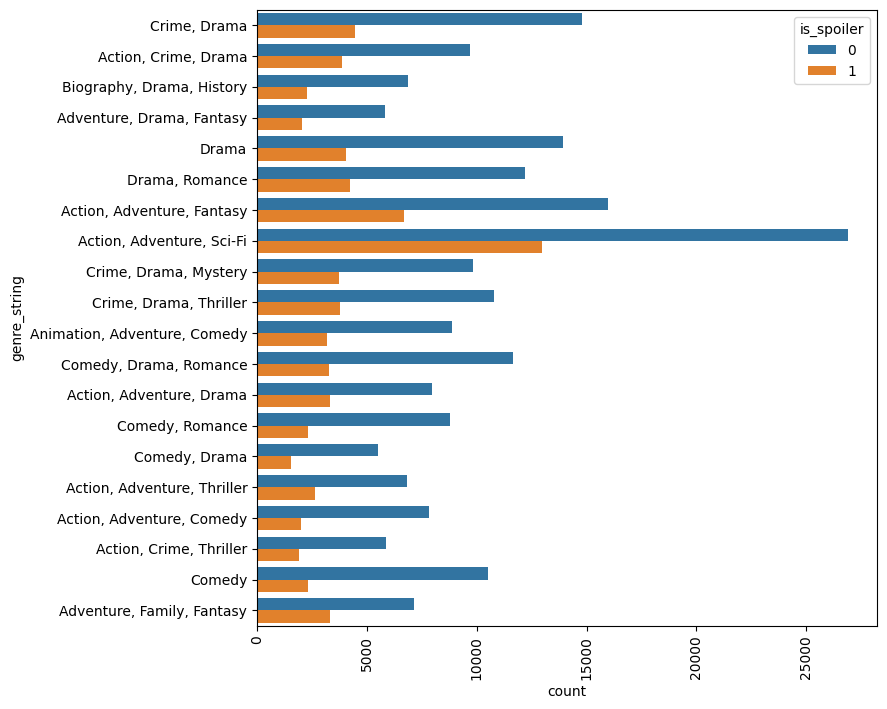

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(y='genre_string', data=df[df.genre_string.isin(most_frequent_genres)], hue='is_spoiler')
plt.xticks(rotation=90)
plt.show()

## Class Distribution

Number of reviews with Spoilers: 150924 (26.30%)
Number of reviews without Spoilers: 422982 (73.70%)


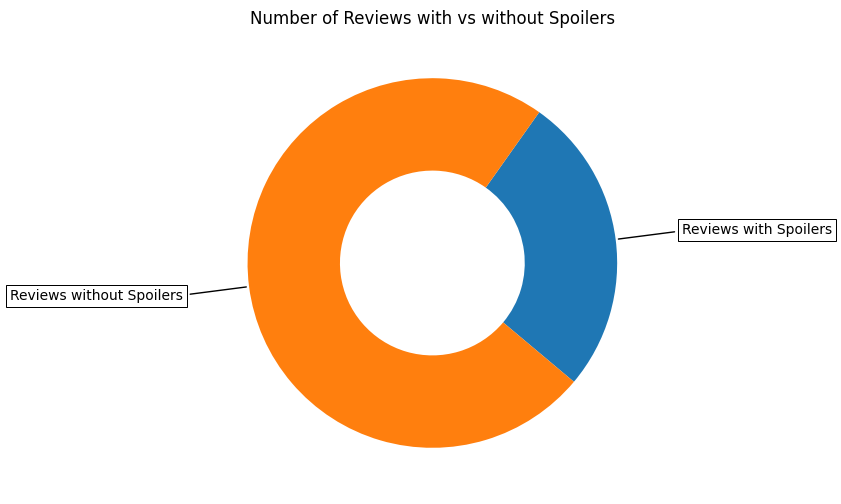

In [ ]:
# Calculate value counts
y_value_counts = df['is_spoiler'].value_counts()
total_projects = y_value_counts.sum()

# Print summary
print("Number of reviews with Spoilers:", y_value_counts[1], f"({(y_value_counts[1] / total_projects) * 100:.2f}%)")
print("Number of reviews without Spoilers:", y_value_counts[0], f"({(y_value_counts[0] / total_projects) * 100:.2f}%)")

# Plot pie chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
data = [y_value_counts[1], y_value_counts[0]]
wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

# Annotation
recipe = ["Reviews with Spoilers", "Reviews without Spoilers"]
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1) / 2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35 * np.sign(x), 1.4 * y),
                 horizontalalignment=horizontalalignment, **kw)

# Set title and display plot
ax.set_title("Number of Reviews with vs without Spoilers")
plt.show()

The dataset is heavily class imbalanced. Only about one-fourth of all reviews are classified as containing spoilers. Also, the dataset is too large to work with on limited GPU. Let's use a subset, while also balancing the same. This will help us optimize for compute while also ensuring that our dataset is class balanced.

Here we working with a total dataset of 25000 datapoints with 12500 datapoints each for spoiler and no-spoiler based reviews.

In [ ]:
total_datapoints_needed = 25000

df_is_spoiler = df[df['is_spoiler'] == 1]
df_is_spoiler = df_is_spoiler.sample(frac=((total_datapoints_needed/2)/df_is_spoiler.shape[0]))

df_no_spoiler = df[df['is_spoiler'] == 0]
df_no_spoiler = df_no_spoiler.sample(frac=((total_datapoints_needed/2)/df_no_spoiler.shape[0]))

# merge and shuffle
df_balanced_subset = pd.concat([df_is_spoiler, df_no_spoiler], axis=0).sample(frac=1)

In [ ]:
df_balanced_subset['is_spoiler'].value_counts()

,count
is_spoiler,
1,12500
0,12500


The dataset is now balanced and forms a subset of the original dataset.

## Word Count Distribution

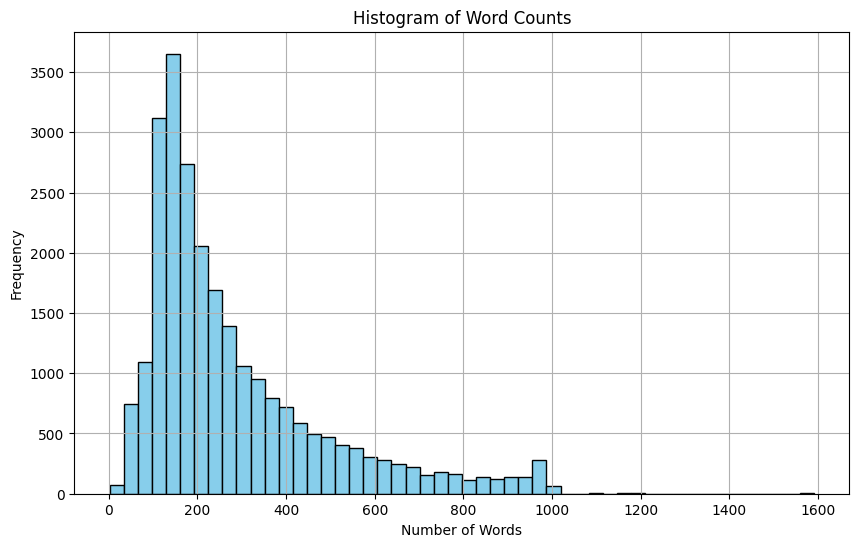

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'texts' is your list of texts

# Tokenize texts and count the number of words in each text
word_counts = [len(text.split()) for text in df_balanced_subset['review_text'].tolist()]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Counts')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

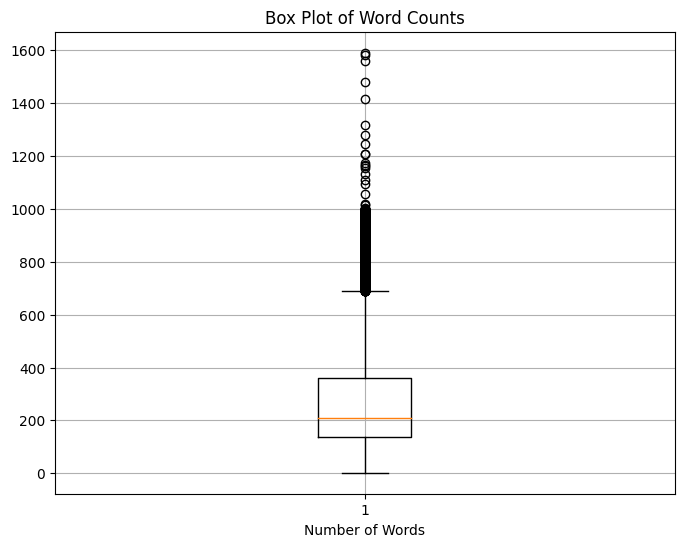

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'texts' is your list of texts

# Tokenize texts and count the number of words in each text
word_counts = [len(text.split()) for text in df_balanced_subset['review_text'].tolist()]

# Plot box plot
plt.figure(figsize=(8, 6))
plt.boxplot(word_counts)
plt.title('Box Plot of Word Counts')
plt.xlabel('Number of Words')
plt.grid(True)
plt.show()

The median value for the number of words lie at about 200 words. The words distribution is skewed with most of the reviews under 700 words but there are outliers beyond this range. Also, these are the number of words splitted by space. These values would be different based on the choice of tokenizer.

## Class-wise word count distribution

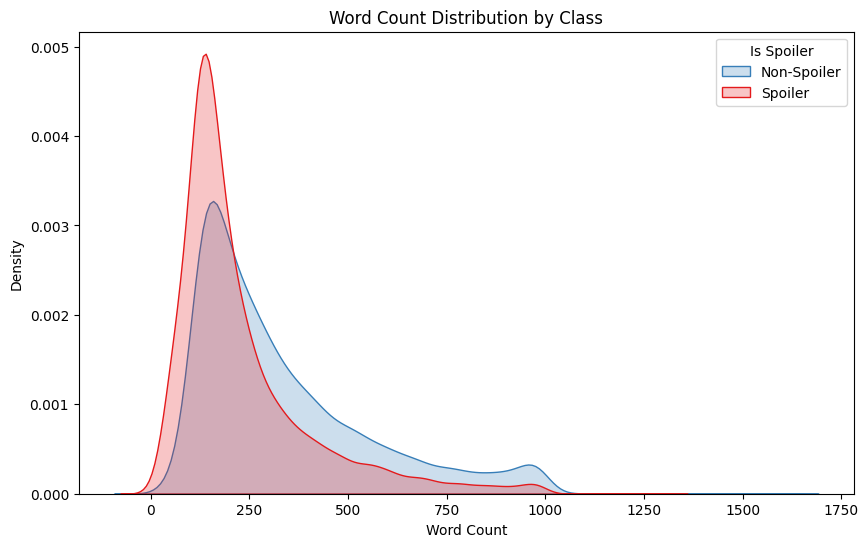

In [ ]:
# Calculate word count for each review
df_balanced_subset['word_count'] = df['review_text'].apply(lambda x: len(x.split()))

# Plot KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_balanced_subset, x='word_count', hue='is_spoiler', fill=True, common_norm=False, palette='Set1')
plt.title('Word Count Distribution by Class')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend(title='Is Spoiler', labels=['Non-Spoiler', 'Spoiler'])
plt.show()

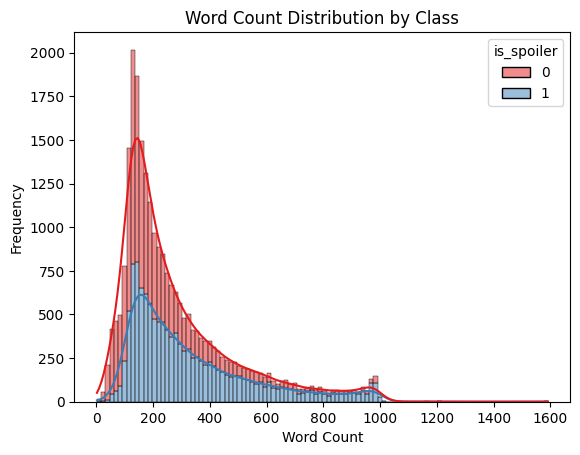

In [ ]:
sns.histplot(data=df_balanced_subset, x='word_count', hue='is_spoiler', multiple='stack', palette='Set1', kde=True)
plt.title('Word Count Distribution by Class')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
# plt.legend()
plt.show()

Up until around 200 words, the density of the KDE plot for spoiler-based reviews is higher. This suggests that there is a higher concentration of spoiler reviews with shorter lengths, up to around 200 words.
Beyond the 200-word mark, the KDE plot for non-spoiler reviews overtakes that of spoiler reviews, consistently showing higher density. This implies that non-spoiler reviews tend to have longer lengths beyond 200 words, and there is a higher concentration of non-spoiler reviews with longer texts. This suggests that spoiler reviews tend to be shorter in length, with a higher density of reviews up to around 200 words, whereas non-spoiler reviews tend to be longer, with a higher density of reviews beyond 200 words.

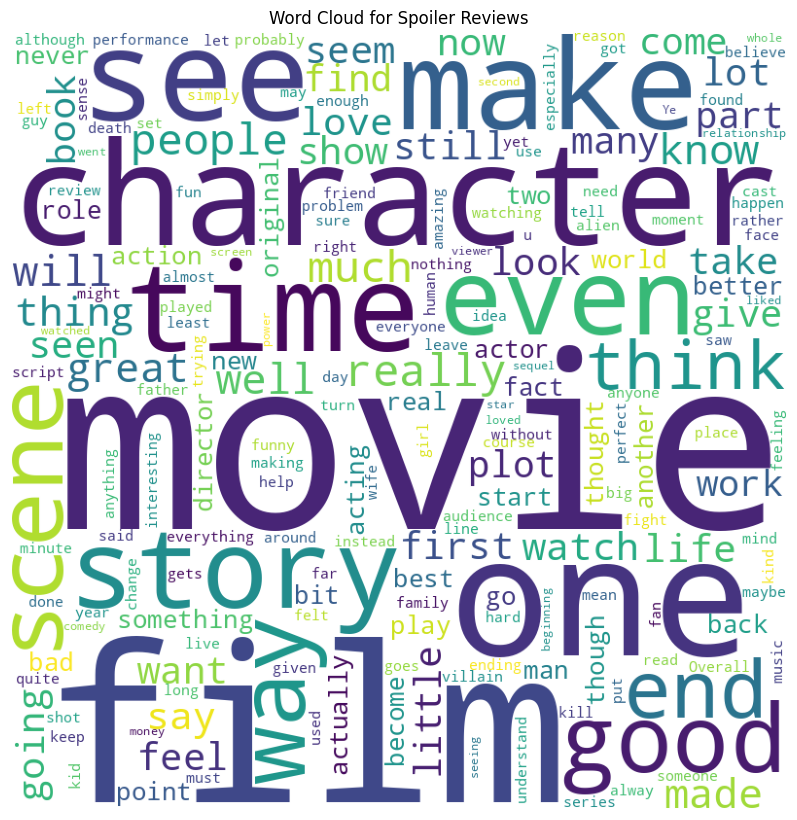

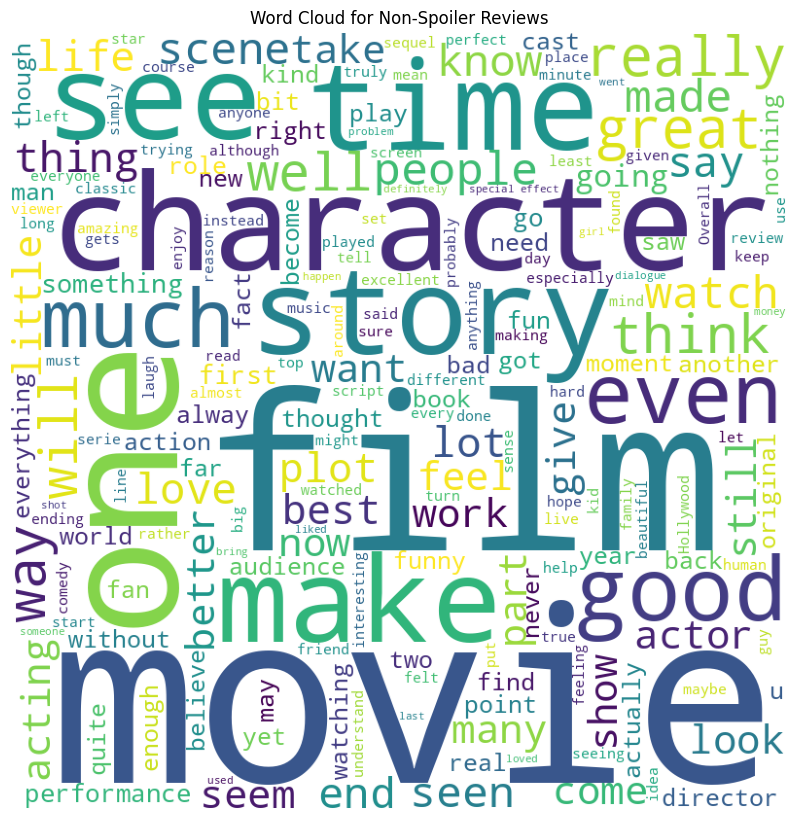

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate spoiler and non-spoiler reviews
spoiler_reviews = df_balanced_subset[df_balanced_subset['is_spoiler'] == 1]['review_text'].values
non_spoiler_reviews = df_balanced_subset[df_balanced_subset['is_spoiler'] == 0]['review_text'].values

# Generate word clouds for spoiler and non-spoiler reviews
spoiler_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(' '.join(spoiler_reviews))

non_spoiler_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(' '.join(non_spoiler_reviews))

# Plot word clouds
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(spoiler_wordcloud)
plt.title('Word Cloud for Spoiler Reviews')
plt.axis("off")
plt.tight_layout(pad = 0)

plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(non_spoiler_wordcloud)
plt.title('Word Cloud for Non-Spoiler Reviews')
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

No noticable distinction exists between commonly occuring words between these two classes.

## Distribution of number of reviews per user

In [ ]:
df['user_id'].value_counts()

,count
user_id,
ur2898520,1303
ur4248714,1021
ur0453068,806
ur60028700,770
ur20552756,755
...,...
ur43186625,1
ur24192106,1
ur42499765,1


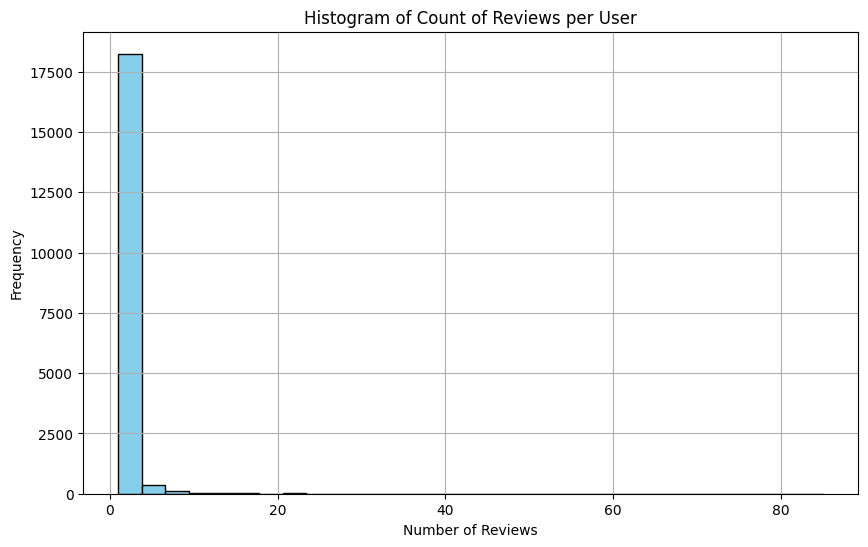

In [ ]:
import matplotlib.pyplot as plt

# Count the number of reviews per user
review_counts_per_user = df_balanced_subset['user_id'].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(review_counts_per_user, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Count of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Most of the users have posted only a single review.

## TFIDF-Based Cosine Similarity between reviews and plot summary

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Function to preprocess text
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Lowercasing and removing punctuation
    tokens = [word.lower() for word in tokens if word.isalnum()]
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Function to calculate similarity
def calculate_similarity(text1, text2):
    # Preprocess the text
#     preprocessed_text1 = preprocess_text(text1)
#     preprocessed_text2 = preprocess_text(text2)
    # Vectorization
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([text1, text2])
    # Calculate cosine similarity
    similarity_score = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]
    return similarity_score

similarity_scores = []

for idx, row in tqdm(df_balanced_subset.iterrows(), total=df_balanced_subset.shape[0]):
    similarity_score = calculate_similarity(row['review_text'], row['plot_summary'])
    similarity_scores.append(similarity_score)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


  0%|          | 0/25000 [00:00<?, ?it/s]

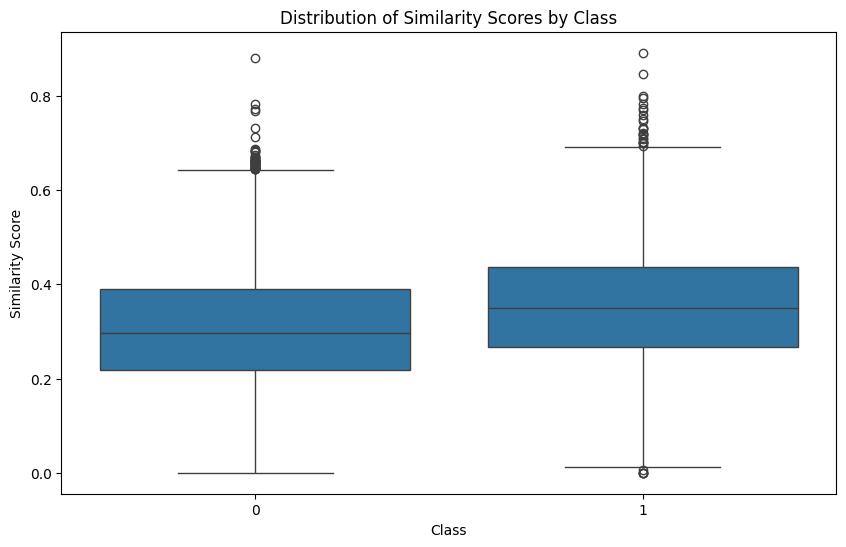

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example similarity scores and classes
classes = df_balanced_subset['is_spoiler'].tolist()

# Create DataFrame
data = {'Similarity Score': similarity_scores, 'Class': classes}
df = pd.DataFrame(data)

# Create box plot or violin plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Similarity Score', data=df)
plt.title('Distribution of Similarity Scores by Class')
plt.xlabel('Class')
plt.ylabel('Similarity Score')
plt.show()

Reviews with spoilers exhibit higher TFIDF similarity with plot summaries within all quartiles. One way to detect spoilers could be computing similarity with movie plots if available.

# Modeling

## Train, Validation and Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the DataFrame into train and test sets
train_df, test_df = train_test_split(df_balanced_subset, test_size=0.3, random_state=42)

# Further splitting the test set into test and validation sets
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Displaying the shapes of the resulting sets
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("Validation set shape:", val_df.shape)


Train set shape: (17500, 15)
Test set shape: (3750, 15)
Validation set shape: (3750, 15)


## Train function

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Function to train the model
def train(model, train_loader, val_loader, optimizer, epoch, device):
    model.train()  # Set the model in training mode
    total_loss = 0.0  # Initialize a variable to store the total loss
    for batch in tqdm(train_loader, leave=False):  # Iterate over training data batches and display a progress bar
        input_ids, attention_mask, labels = batch  # Unpack batch into input IDs, attention masks, and labels
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)  # Move data to the specified device (e.g., GPU)

        optimizer.zero_grad()  # Zero out the gradients in the optimizer

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)  # Perform a forward pass

        loss = outputs.loss

        loss.backward()  # Backpropagate the gradients
        optimizer.step()  # Update the model's parameters based on the gradients

        total_loss += loss.item()  # Accumulate the loss

    avg_train_loss = total_loss / len(train_loader)  # Calculate the average training loss

    total_loss = 0

    for batch in tqdm(val_loader, leave=False):  # Iterate over val data batches and display a progress bar
        input_ids, attention_mask, labels = batch  # Unpack batch into input IDs, attention masks, and labels
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)  # Move data to the specified device (e.g., GPU)

        model.eval()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)  # Perform a forward pass
        loss = outputs.loss
        total_loss += loss.item()  # Accumulate the loss

    avg_val_loss = total_loss / len(val_loader)  # Calculate the average training loss

    print(f'Epoch {epoch + 1} - Average Train Loss: {avg_train_loss:.4f}')  # Print the average training loss for the epoch
    print(f'Epoch {epoch + 1} - Average Validation Loss: {avg_val_loss:.4f}')  # Print the average training loss for the epoch
    return avg_train_loss, avg_val_loss  # Return the average training loss

## Confusion Matrix and Test function

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize=(4, 3), fontsize=14):
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the outputted figure,
        the second determining the vertical size. Defaults to (4, 3).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Function to test the model
def test(model, test_loader, device):
    model.eval()  # Set the model in evaluation mode
    all_true_labels_in_epoch = []  # Initialize a list to store true labels for the epoch
    all_predictions_in_epoch = []  # Initialize a list to store predicted labels for the epoch

    with torch.no_grad():  # Disable gradient calculation for testing
        for batch in tqdm(test_loader, leave=False):  # Iterate over test data batches and display a progress bar
            input_ids, attention_mask, labels = batch  # Unpack batch into input IDs, attention masks, and labels
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)  # Move data to the specified device

            outputs = model(input_ids, attention_mask=attention_mask)  # Perform a forward pass without labels
            logits = outputs.logits  # Get the model's output logits

            predicted_labels = torch.argmax(logits, dim=1)  # Get the predicted labels

            all_predictions_in_epoch.extend(predicted_labels.tolist())  # Append predicted labels to the list
            all_true_labels_in_epoch.extend(labels.tolist())  # Append true labels to the list

    # Calculate classification report
    report = classification_report(all_true_labels_in_epoch, all_predictions_in_epoch)
    print("Test Classification Report:")
    print(report)

    print_confusion_matrix(confusion_matrix(all_true_labels_in_epoch, all_predictions_in_epoch), ['Not Spoiler', 'Spoiler'])

## Main function to train a BERT Model

Here truncating to a max length of 512, since BERT has a max context length of 512 tokens. Our dataset has datapoints more than the context length of BERT.

In [ ]:
train_losses = []
val_losses = []

# Main function for training
def main(args):

    batch_size = args['batch_size']  # Get the batch size from the arguments
    learning_rate = args['learning_rate']  # Get the learning rate from the arguments
    epochs = args['epochs']  # Get the number of training epochs from the arguments
    max_length = args['max_length']  # Get the maximum sequence length from the arguments

    # Get a subset of the dataset for training and testing
    train_texts, train_labels, val_texts, val_labels, test_texts, test_labels = train_df['review_text'].tolist(), train_df['is_spoiler'].tolist(), \
    val_df['review_text'].tolist(), val_df['is_spoiler'].tolist(), test_df['review_text'].tolist(), test_df['is_spoiler'].tolist()

#     train_texts, train_labels = random_undersample(train_texts, train_labels)

    model_name = "google-bert/bert-base-uncased"

    # Initialize BERT tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.truncation_side='left'

    # Tokenize and encode the text data
    print("Tokenizing Train Dataset")
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')  # Tokenize training data
    print("Tokenizing Validation Dataset")
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')  # Tokenize validation data
    print("Tokenizing Test Dataset")
    test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')  # Tokenize test data

    # Create PyTorch datasets
    print("Train, Validation and Test Assignment")
    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'],
                                    torch.tensor(train_labels))  # Create a training dataset
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'],
                                    torch.tensor(val_labels))  # Create a validation dataset
    test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'],
                                    torch.tensor(test_labels))  # Create a test dataset

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Create a data loader for training data
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # Create a data loader for validation data
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Create a data loader for test data

    # Define the BERT-based text classifier model
    print("Loading Model")
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Binary classification

    # Define optimizer and learning rate scheduler
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.01)  # Define the optimizer

    # Training loop

    model.to(device)  # Move the model to the specified device
    print("Training on " + str(device))  # Print the device being used for training

    for epoch in tqdm(range(epochs)):  # Iterate through training epochs
        train_loss, val_loss = train(model, train_loader, val_loader, optimizer, epoch, device)  # Perform training and get the average loss
        test(model, test_loader, device)  # Perform testing and get accuracy

        train_losses.append(round(train_loss, 2))
        val_losses.append(round(val_loss, 2))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing Train Dataset
Tokenizing Validation Dataset
Tokenizing Test Dataset
Train, Validation and Test Assignment
Loading Model


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on cuda


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1094 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1 - Average Train Loss: 0.6818
Epoch 1 - Average Validation Loss: 0.6517


  0%|          | 0/235 [00:00<?, ?it/s]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.60      0.62      1897
           1       0.61      0.66      0.64      1853

    accuracy                           0.63      3750
   macro avg       0.63      0.63      0.63      3750
weighted avg       0.63      0.63      0.63      3750



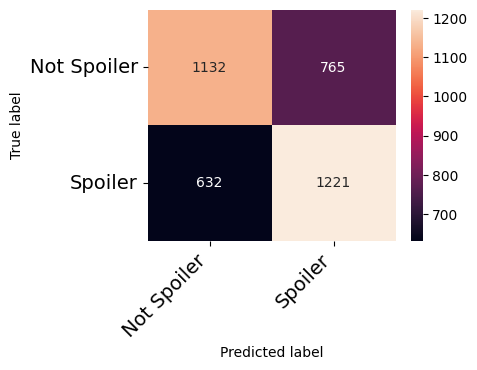

  0%|          | 0/1094 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2 - Average Train Loss: 0.6389
Epoch 2 - Average Validation Loss: 0.6182


  0%|          | 0/235 [00:00<?, ?it/s]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.71      0.67      1897
           1       0.66      0.58      0.62      1853

    accuracy                           0.65      3750
   macro avg       0.65      0.64      0.64      3750
weighted avg       0.65      0.65      0.64      3750



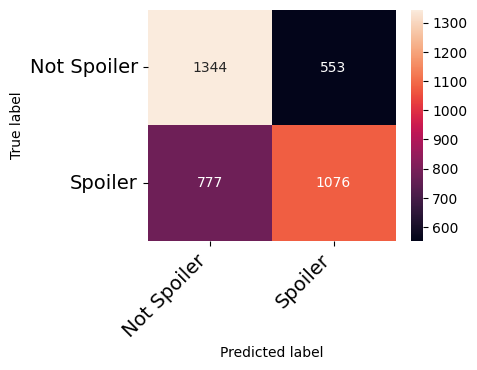

  0%|          | 0/1094 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3 - Average Train Loss: 0.6195
Epoch 3 - Average Validation Loss: 0.6014


  0%|          | 0/235 [00:00<?, ?it/s]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.64      0.65      1897
           1       0.65      0.68      0.66      1853

    accuracy                           0.66      3750
   macro avg       0.66      0.66      0.66      3750
weighted avg       0.66      0.66      0.66      3750



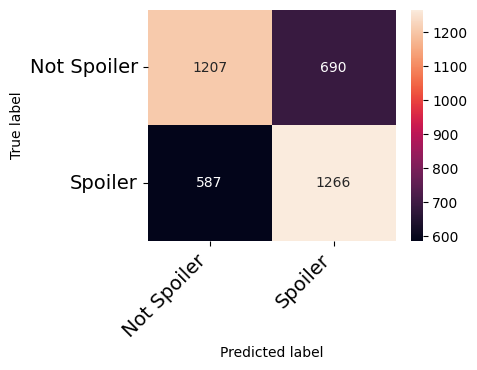

  0%|          | 0/1094 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4 - Average Train Loss: 0.6088
Epoch 4 - Average Validation Loss: 0.5963


  0%|          | 0/235 [00:00<?, ?it/s]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.67      1897
           1       0.67      0.65      0.66      1853

    accuracy                           0.67      3750
   macro avg       0.67      0.67      0.67      3750
weighted avg       0.67      0.67      0.67      3750



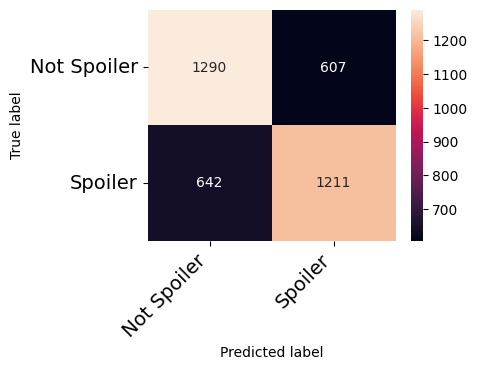

  0%|          | 0/1094 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5 - Average Train Loss: 0.6018
Epoch 5 - Average Validation Loss: 0.5978


  0%|          | 0/235 [00:00<?, ?it/s]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.75      0.69      1897
           1       0.69      0.59      0.64      1853

    accuracy                           0.67      3750
   macro avg       0.67      0.67      0.67      3750
weighted avg       0.67      0.67      0.67      3750



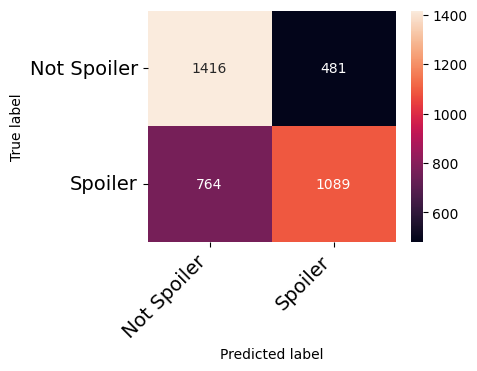

In [ ]:
if __name__ == '__main__':

    batch_size = 16  # Calculate the total effective batch size

    args = {'batch_size': batch_size, 'learning_rate': 2e-4, 'epochs': 5, 'max_length': 512}  # Create a dictionary of training arguments

    main(args)  # Start the training process

In [ ]:
print(train_losses)
print(val_losses)

[0.68, 0.64, 0.62, 0.61, 0.6]
[0.65, 0.62, 0.6, 0.6, 0.6]


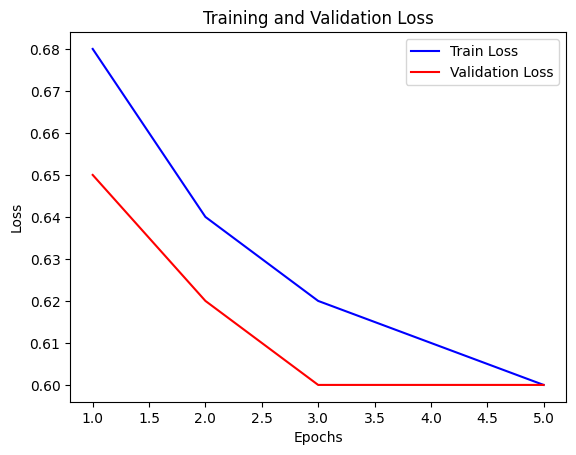

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Result Analysis

* BERT yields an acceptable F1-Score of 67%
* The reviews are truncated to 512 tokens which may result in poor predictions. One way to tackle this can be to use larger context transformers.
* As we noticed that reviews with spoilers have higher TFIDF vectors based similarity scores with movie plot summaries, than the reviews without spoilers, another way and a future endevour may involve experimenting with semantic similarity based approaches to examine if a review has spoiler. That would be faster but be limited by the availability of a plot summary.